# Final Real Estate AI Pipeline

Optimized for Business Value & High Accuracy.

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score, classification_report
import xgboost as xgb
import joblib
import os
import warnings
warnings.filterwarnings('ignore')

## 1. Data Cleaning & Understanding

In [45]:
# Load Data
import pandas as pd

df = pd.read_csv('/kaggle/input/housedata/data.csv')

# Convert date
df['date'] = pd.to_datetime(df['date'])

# Keep only allowed columns and drop missing values
allowed_cols = [
    'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 
    'floors', 'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement', 
    'yr_built', 'yr_renovated', 'street', 'city', 'statezip', 'country'
]
df = df[allowed_cols].dropna()

# Remove outliers using IQR method
q_low = df["price"].quantile(0.01)
q_hi  = df["price"].quantile(0.99)
df_clean = df[(df["price"] > q_low) & (df["price"] < q_hi)]

print(f"Original: {df.shape}, Cleaned: {df_clean.shape}")

# Replace df with cleaned version
df = df_clean.copy()


Original: (4600, 18), Cleaned: (4505, 18)


## 2. Advanced Feature Engineering

In [46]:
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler


# 1. City Rank
city_price_map = df.groupby('city')['price'].median().sort_values().to_dict()
df['city_enc'] = df['city'].map(city_price_map)

# 2. Derived Time Features
df['house_age'] = 2026 - df['yr_built']
df['was_renovated'] = df['yr_renovated'].apply(lambda x: 1 if x > 0 else 0)


# 3. Log Target
y = np.log1p(df['price'])

# Save Encoders / Stats for App
stats = {
    'median_price': df['price'].median(),
    'avg_price_sqft': (df['price'] / df['sqft_living']).mean(),
    'city_map': city_price_map
}
joblib.dump(stats, 'market_stats.pkl')

# 4. Feature Selection
drop_cols = ['date', 'street', 'city', 'statezip', 'country']
X = df.drop(drop_cols, axis=1, errors='ignore')

# 5. Scaling
cols = X.columns
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=cols)

print("Engineering Complete. Features:")
print(X_scaled.head())


Engineering Complete. Features:
      price  bedrooms  bathrooms  sqft_living  sqft_lot    floors  waterfront  \
0 -0.741677 -0.428290  -0.852630    -0.861440 -0.190429 -0.016912   -0.070053   
1 -0.641962 -0.428290  -0.184845    -0.195160 -0.077785 -0.946037   -0.070053   
2 -0.373763 -0.428290   0.149047    -0.116110 -0.187135 -0.946037   -0.070053   
3  0.073237  0.685067   0.482940    -0.183867 -0.118181 -0.946037   -0.070053   
4 -0.133071 -1.541647  -1.520415    -1.380913 -0.233198 -0.946037   -0.070053   

       view  condition  sqft_above  sqft_basement  yr_built  yr_renovated  \
0 -0.298766  -0.665949   -0.565028      -0.679614 -0.531502      1.221338   
1 -0.298766   0.818514    0.158807      -0.679614 -0.161308     -0.825890   
2 -0.298766   0.818514   -0.982153       1.568821 -0.262270     -0.825890   
3 -0.298766   0.818514   -0.810396       1.119134  0.175233      1.208064   
4 -0.298766  -0.665949   -1.129374      -0.679614 -1.103621      1.210106   

   city_enc  house

## 3. Exploratory Analysis & Business Insights

Based on dataset analysis, here are the key drivers and recommendations:

Top Drivers:
 sqft_living    0.676728
sqft_above     0.577497
city_enc       0.546140
bathrooms      0.516239
view           0.348614
Name: price, dtype: float64


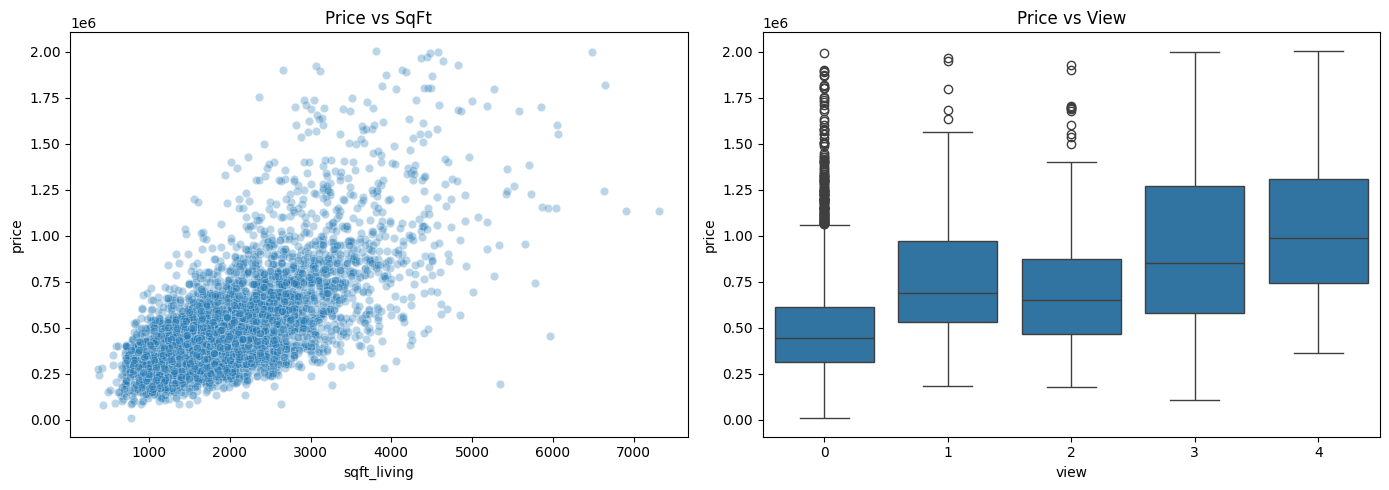

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Price Drivers
numeric_df = df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()['price'].drop('price').sort_values(ascending=False)
print("Top Drivers:\n", corr_matrix.head(5))

# Visuals
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.scatterplot(data=df, x='sqft_living', y='price', alpha=0.3, ax=axes[0]).set_title('Price vs SqFt')
sns.boxplot(data=df, x='view', y='price', ax=axes[1]).set_title('Price vs View')
plt.tight_layout()
plt.show()

# Additional Distribution Analysis
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

# Price distribution
sns.histplot(df['price'], kde=True, ax=ax[0,0]).set_title('Price Distribution')

# Sqft Living distribution
sns.histplot(df['sqft_living'], kde=True, ax=ax[0,1]).set_title('SqFt Living Distribution')

# Bedrooms count
sns.countplot(data=df, x='bedrooms', ax=ax[1,0]).set_title('Bedrooms Count')

# Condition count
sns.countplot(data=df, x='condition', ax=ax[1,1]).set_title('Condition Count')

plt.tight_layout()
plt.show()


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4505 entries, 0 to 4599
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           4505 non-null   datetime64[ns]
 1   price          4505 non-null   float64       
 2   bedrooms       4505 non-null   float64       
 3   bathrooms      4505 non-null   float64       
 4   sqft_living    4505 non-null   int64         
 5   sqft_lot       4505 non-null   int64         
 6   floors         4505 non-null   float64       
 7   waterfront     4505 non-null   int64         
 8   view           4505 non-null   int64         
 9   condition      4505 non-null   int64         
 10  sqft_above     4505 non-null   int64         
 11  sqft_basement  4505 non-null   int64         
 12  yr_built       4505 non-null   int64         
 13  yr_renovated   4505 non-null   int64         
 14  street         4505 non-null   object        
 15  city           4505 non-nu

## 4. Clustering (Unsupervised)

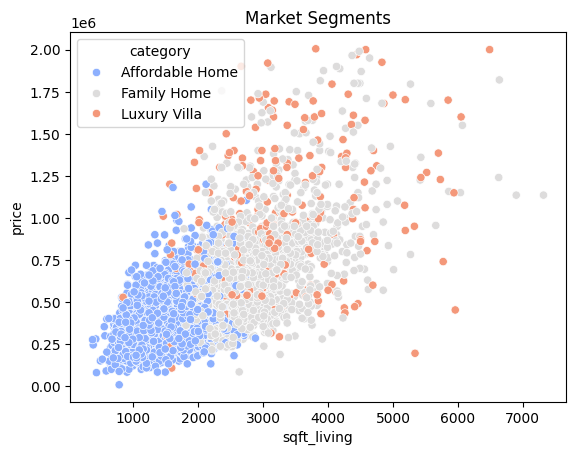

In [49]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

# Features for clustering (top drivers only)
clust_feats = df[['sqft_living', 'sqft_above', 'bathrooms', 'view', 'city_enc']]
X_c = StandardScaler().fit_transform(clust_feats)

# KMeans clustering
km = KMeans(n_clusters=3, random_state=42)
df['cluster'] = km.fit_predict(X_c)

# Map clusters to meaningful categories using average price
means = df.groupby('cluster')['price'].mean().sort_values()
mapping = {
    means.index[0]: 'Affordable Home',
    means.index[1]: 'Family Home',
    means.index[2]: 'Luxury Villa'
}
df['category'] = df['cluster'].map(mapping)

# Plot clusters (sqft_living vs price for interpretation)
sns.scatterplot(data=df, x='sqft_living', y='price', hue='category', palette='coolwarm')
plt.title('Market Segments')
plt.show()

In [50]:
X_scaled

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,city_enc,house_age,was_renovated
0,-0.741677,-0.428290,-0.852630,-0.861440,-0.190429,-0.016912,-0.070053,-0.298766,-0.665949,-0.565028,-0.679614,-0.531502,1.221338,-0.778987,0.531502,1.210699
1,-0.641962,-0.428290,-0.184845,-0.195160,-0.077785,-0.946037,-0.070053,-0.298766,0.818514,0.158807,-0.679614,-0.161308,-0.825890,-1.286535,0.161308,-0.825969
2,-0.373763,-0.428290,0.149047,-0.116110,-0.187135,-0.946037,-0.070053,-0.298766,0.818514,-0.982153,1.568821,-0.262270,-0.825890,1.567103,0.262270,-0.825969
3,0.073237,0.685067,0.482940,-0.183867,-0.118181,-0.946037,-0.070053,-0.298766,0.818514,-0.810396,1.119134,0.175233,1.208064,1.048320,-0.175233,1.210699
4,-0.133071,-1.541647,-1.520415,-1.380913,-0.233198,-0.946037,-0.070053,-0.298766,-0.665949,-1.129374,-0.679614,-1.103621,1.210106,0.076840,1.103621,1.210699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4500,-0.758297,-0.428290,-0.518738,-0.669461,-0.233756,-0.946037,-0.070053,-0.298766,0.818514,-0.356466,-0.679614,-0.565156,1.194790,0.076840,0.565156,1.210699
4501,0.019368,-0.428290,0.482940,-0.725926,-0.199893,0.912213,-0.070053,-0.298766,-0.665949,-0.417808,-0.679614,0.410811,1.225422,1.567103,-0.410811,1.210699
4502,-0.384407,-0.428290,0.482940,1.024471,-0.215498,0.912213,-0.070053,-0.298766,-0.665949,1.483792,-0.679614,1.285816,-0.825890,-0.878117,-1.285816,-0.825969
4503,-1.118532,0.685067,-0.184845,-0.014474,-0.226219,-0.946037,-0.070053,-0.298766,-0.665949,-0.896275,1.613790,0.107925,-0.825890,0.076840,-0.107925,-0.825969


## 5. Classification (Supervised)

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import joblib

# Prepare data
X_scaled.drop(columns=['price'], inplace=True)
X_final = X_scaled.values
y_cls = df['category'].values

# Split
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_final, y_cls, test_size=0.2, random_state=42
)

# Train classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_c, y_train_c)

# Save model and feature names
joblib.dump(clf, 'category_classifier.pkl')
joblib.dump(X_scaled.columns.tolist(), 'cls_features.pkl')

# Evaluation
print("Classification Report:")
print(classification_report(y_test_c, clf.predict(X_test_c)))


Classification Report:
                 precision    recall  f1-score   support

Affordable Home       0.98      0.98      0.98       526
    Family Home       0.96      0.96      0.96       314
   Luxury Villa       0.98      0.98      0.98        61

       accuracy                           0.97       901
      macro avg       0.98      0.98      0.98       901
   weighted avg       0.97      0.97      0.97       901



## 6. Price Regression (Supervised)

In [52]:
import xgboost as xgb
import joblib
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

# Prepare target
y_reg = y.values  # log-transformed price


# Train-test split
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_final, y_reg, test_size=0.2, random_state=42
)

# Train XGBoost Regressor
print("Training XGBoost Regressor...")
model = xgb.XGBRegressor(
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=6,
    subsample=0.7,
    colsample_bytree=0.7,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train_r, y_train_r)

# Save model and features
joblib.dump(model, 'price_regressor.pkl')
joblib.dump(X_scaled.columns.tolist(), 'reg_features.pkl')

# Evaluation
preds_log = model.predict(X_test_r)
preds_dollar = np.expm1(preds_log)
y_true_dollar = np.expm1(y_test_r)

r2 = r2_score(y_true_dollar, preds_dollar)
mae = mean_absolute_error(y_true_dollar, preds_dollar)

print(f"Final R2 Score: {r2:.4f}")
print(f"Final MAE: ${mae:,.0f}")


Training XGBoost Regressor...
Final R2 Score: 0.6941
Final MAE: $93,410
